In [1]:
import xarray as xr
import xgcm
import matplotlib.pyplot as plt
import numpy as np
import xmitgcm as xm

import cmocean

import sys
sys.path.append('/nethome/4302001/diffusion-hydro-mod/tools/')
import ACC_tools

In [2]:
data_dir = "/data/oceanparcels/input_data/MITgcm/ACC_channel/"
ds_fine = xr.open_dataset(data_dir + "ACC_ridge_fine_1y_locb.nc")
ds_coarsened = xr.open_dataset(data_dir + "ACC_ridge_fine_1y_locb_coarsened_tave_fixtemp_with_derivative.nc")
ds_coarse = xr.open_dataset(data_dir + "ACC_ridge_coarse_1y_locb_fixtemp_with_derivative.nc")

In [3]:
metrics = {
    ('X',): ['dxC', 'dxG','dxF', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG','dyF', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid_fine = xgcm.Grid(ds_fine, periodic=['X'], metrics=metrics, boundary='extend')
grid_coarse = xgcm.Grid(ds_coarse, periodic=['X'], metrics=metrics, boundary='extend')

In [4]:
zeta_fine = (-grid_fine.diff(ds_fine.UVEL.isel(time=0, Z=24) * ds_fine.dxC, 'Y') + grid_fine.diff(ds_fine.VVEL.isel(time=0, Z=24) * ds_fine.dyC, 'X'))/ds_fine.rAz
zeta_coarsened = (-grid_coarse.diff(ds_coarsened.UVEL.isel(Z=24) * ds_coarsened.dxC, 'Y') + grid_coarse.diff(ds_coarsened.VVEL.isel(Z=24) * ds_coarsened.dyC, 'X'))/ds_coarse.rAz
zeta_coarse = (-grid_coarse.diff(ds_coarse.UVEL.isel(time=0, Z=24) * ds_coarse.dxC, 'Y') + grid_coarse.diff(ds_coarse.VVEL.isel(time=0, Z=24) * ds_coarse.dyC, 'X'))/ds_coarse.rAz

In [5]:
f0=-1.363e-4
beta=1.313e-11,

In [7]:
topography_coarse = ACC_tools.read_binary_field("/nethome/4302001/diffusion-hydro-mod/ACC_mitgcm_config/GCM/reentrant_coarse/input_ridge_1y_tracer_locb/bathy.50km.bin",
                                                (40,20),
                                                dtype=np.dtype('float32'))

/tmp/ipykernel_36216/3134839262.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.arange(0,2001, 250))
/tmp/ipykernel_36216/3134839262.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(np.arange(0,1001, 250))


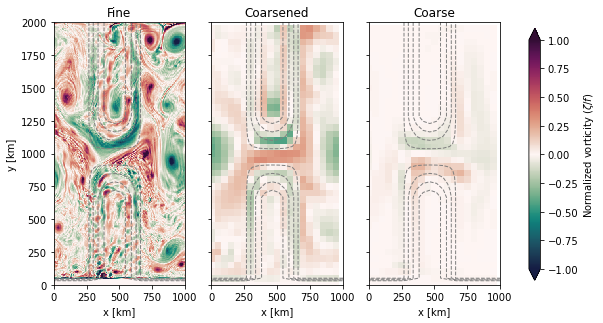

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(8,5))

vort_fine_img = (zeta_fine*2*np.pi/(ds_fine.YG*beta+f0)).plot(ax=ax[0], vmin=-1, vmax=1, cmap=cmocean.cm.curl, add_colorbar=False)
ax[0].set_title('Fine')

vort_coarsened_img = (zeta_coarsened*2*np.pi/(ds_coarsened.YG*beta+f0)).plot(ax=ax[1], vmin=-1, vmax=1, cmap=cmocean.cm.curl, add_colorbar=False)
ax[1].set_title('Coarsened')

vort_coarse_img = (zeta_coarse*2*np.pi/(ds_coarse.YG*beta+f0)).plot(ax=ax[2], vmin=-1, vmax=1, cmap=cmocean.cm.curl, add_colorbar=False)
ax[2].set_title('Coarse')



for i in range(3):
    ax[i].contour(np.linspace(-1e6, 4e6, 100), 
                        np.linspace(0, 2e6, 40),
                        np.tile(topography_coarse, 5), 
                        levels=np.arange(-3900, -2000, 500),
                        colors=['grey'],
                        linestyles='dashed',
                        linewidths=1,
                        zorder=2)
    ax[i].set_xlim(0, 1e6)
    ax[i].set_ylim(0, 2e6)
    ax[i].set_aspect(1)
    if i > 0:
        ax[i].set_yticklabels([])
    else:
        ax[i].set_ylabel("y [km]")
        ax[i].set_yticklabels(np.arange(0,2001, 250))
    ax[i].set_xlabel("x [km]")
    ax[i].set_xticklabels(np.arange(0,1001, 250))

ax[1].set_ylabel(None)
ax[2].set_ylabel(None)


    
cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cbar = plt.colorbar(vort_fine_img, cax=cax, shrink=0.5, extend='both', label=r'Normalized vorticity ($\zeta/f$)')
plt.savefig('out/vorticity.png', dpi=600, bbox_inches='tight')

/tmp/ipykernel_36216/1898373701.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.arange(0,2001, 250))
/tmp/ipykernel_36216/1898373701.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(np.arange(0,1001, 250))


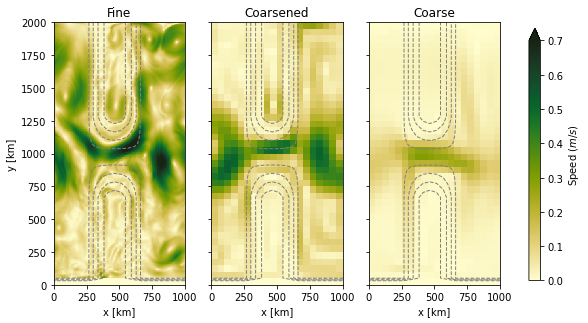

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(8,5))

speed_fine_img = (np.sqrt(grid_fine.interp(ds_fine.isel(time=0, Z=24).UVEL**2, axis='X', to='center') + grid_fine.interp(ds_fine.isel(time=0, Z=24).VVEL**2, axis='Y', to='center'))).plot(ax=ax[0], vmin=0, vmax=0.7, cmap=cmocean.cm.speed, add_colorbar=False)
ax[0].set_title('Fine')

speed_coarsened_img = (np.sqrt(grid_coarse.interp(ds_coarsened.isel(Z=24).UVEL**2, axis='X', to='center') + grid_coarse.interp(ds_coarsened.isel(Z=24).VVEL**2, axis='Y', to='center'))).plot(ax=ax[1], vmin=0, vmax=0.7, cmap=cmocean.cm.speed, add_colorbar=False)
ax[1].set_title('Coarsened')

speed_coarse_img = (np.sqrt(grid_coarse.interp(ds_coarse.isel(time=0, Z=24).UVEL**2, axis='X', to='center') + grid_coarse.interp(ds_coarse.isel(time=0, Z=24).VVEL**2, axis='Y', to='center'))).plot(ax=ax[2], vmin=0, vmax=0.7, cmap=cmocean.cm.speed, add_colorbar=False)
ax[2].set_title('Coarse')



for i in range(3):
    ax[i].contour(np.linspace(-1e6, 4e6, 100), 
                        np.linspace(0, 2e6, 40),
                        np.tile(topography_coarse, 5), 
                        levels=np.arange(-3900, -2000, 500),
                        colors=['grey'],
                        linestyles='dashed',
                        linewidths=1,
                        zorder=2)
    ax[i].set_xlim(0, 1e6)
    ax[i].set_ylim(0, 2e6)
    ax[i].set_aspect(1)
    if i > 0:
        ax[i].set_yticklabels([])
    else:
        ax[i].set_ylabel("y [km]")
        ax[i].set_yticklabels(np.arange(0,2001, 250))
    ax[i].set_xlabel("x [km]")
    ax[i].set_xticklabels(np.arange(0,1001, 250))

ax[1].set_ylabel(None)
ax[2].set_ylabel(None)
    
cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cbar = plt.colorbar(speed_fine_img, cax=cax, shrink=0.5, extend='max', label=r'Speed ($m/s$)')
plt.savefig('out/speed.png', dpi=600, bbox_inches='tight')